# Multivariate Time Series Prediction of COVID-19 Cases in Kano State, Nigeria using LSTM, GRU, CNN and TCN Models
Using the different models, We will predict:
- Confirmed Cases
- Deaths
- Discharged Patients


###  Evaluation Metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² Score

# Install Keras-tcn for the TCN Libraries

In [1]:
#Install Keras-tcn Package into the Google Colab environment
!pip install keras-tcn --quiet

# Install all the necessary Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from tcn import TCN

# Load the Dataset into your environment and create the dataframe

In [13]:
# Load Dataset
url = 'https://raw.githubusercontent.com/mkumakech/Covid-19_Pandemic/refs/heads/master/kano%20(1).csv'
df = pd.read_csv(url)

In [14]:
df.head()

,State,Confirmed,Discharged,Death,Date
0,Kano,92,0,0,01/05/2020
1,Kano,2,7,3,02/05/2020
2,Kano,29,0,0,03/05/2020
3,Kano,23,0,2,04/05/2020
4,Kano,32,3,3,05/05/2020


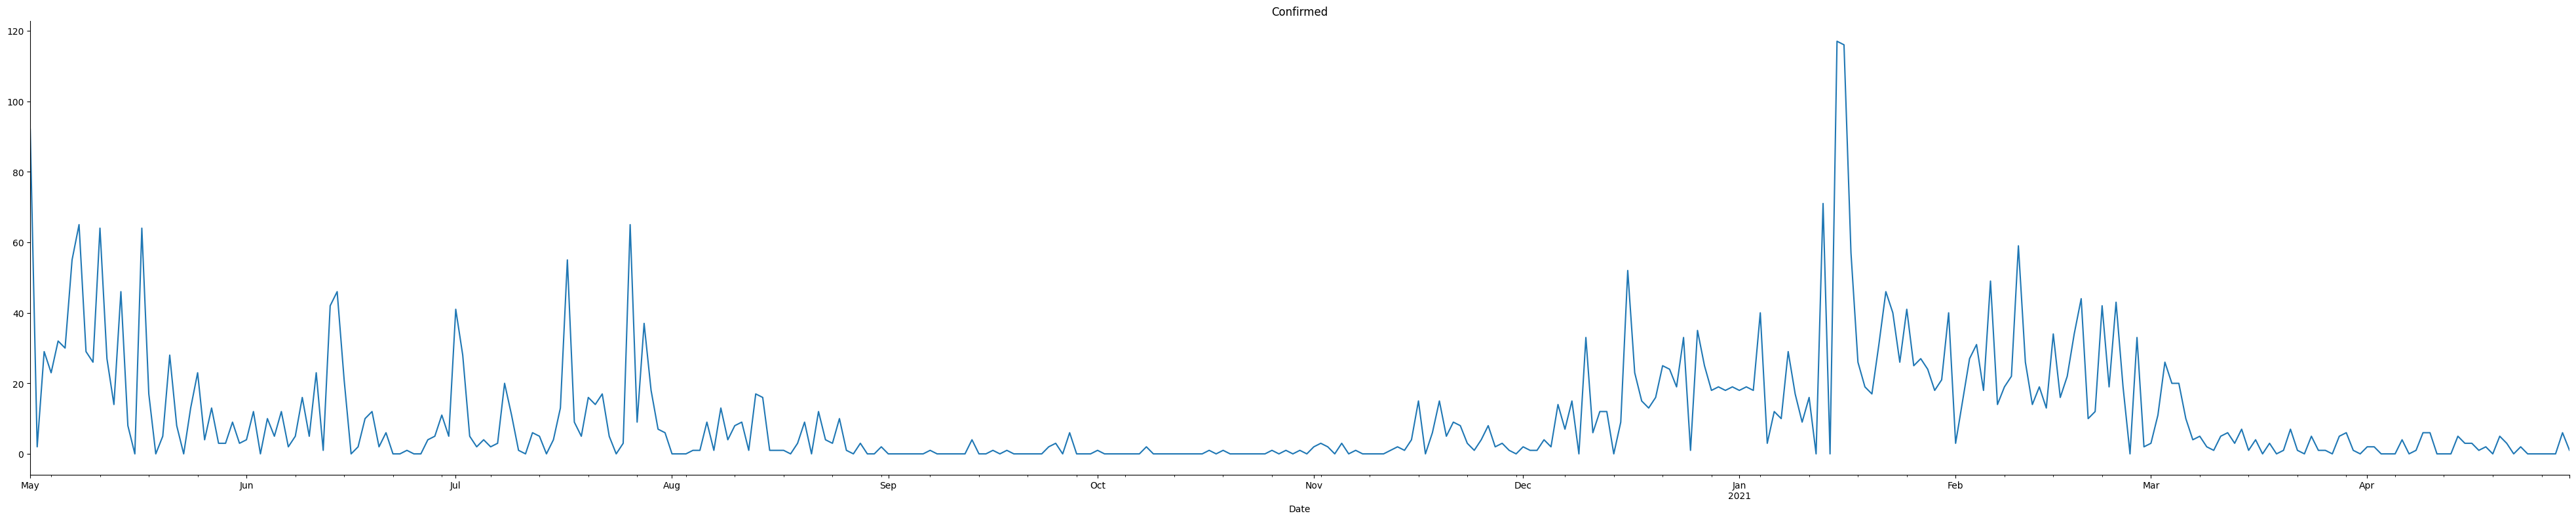

In [41]:
# @title Confirmed

from matplotlib import pyplot as plt
df['Confirmed'].plot(kind='line', figsize=(50, 9), title='Confirmed')
plt.gca().spines[['top', 'right']].set_visible(False)

# Data Selection and Preprocessing

Convert the date to datetime and sort the data frame. Also set the date as index

In [15]:

df = df[['Date', 'Confirmed', 'Death', 'Discharged']]
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date')
df = df.set_index('Date')
df.head()

<ipython-input-15-6f83f0a01543>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')


,Confirmed,Death,Discharged
Date,,,
2020-05-01,92,0,0
2020-05-02,2,3,7
2020-05-03,29,0,0
2020-05-04,23,2,0
2020-05-05,32,3,3


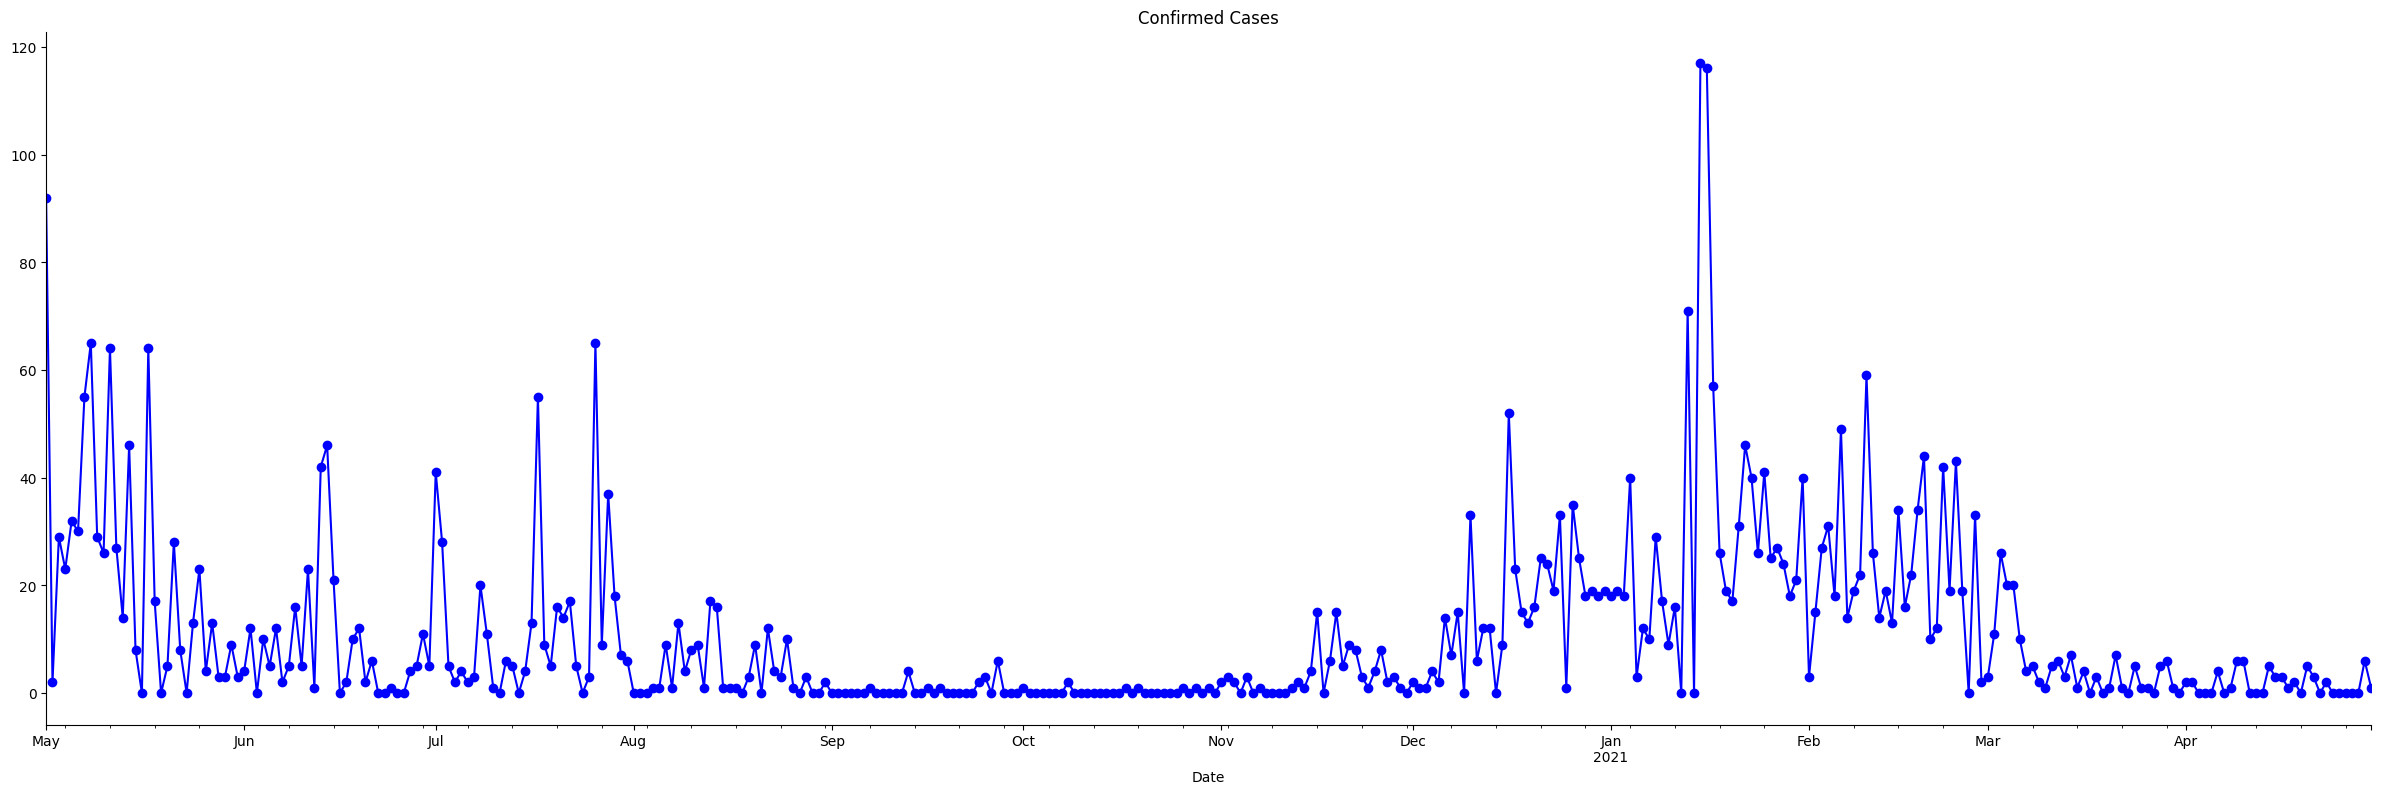

In [87]:
# Confirmed Cases

from matplotlib import pyplot as plt
df['Confirmed'].plot(kind='line', figsize=(30, 9), title='Confirmed Cases', color='blue', marker='o')
plt.gca().spines[['top', 'right']].set_visible(False)

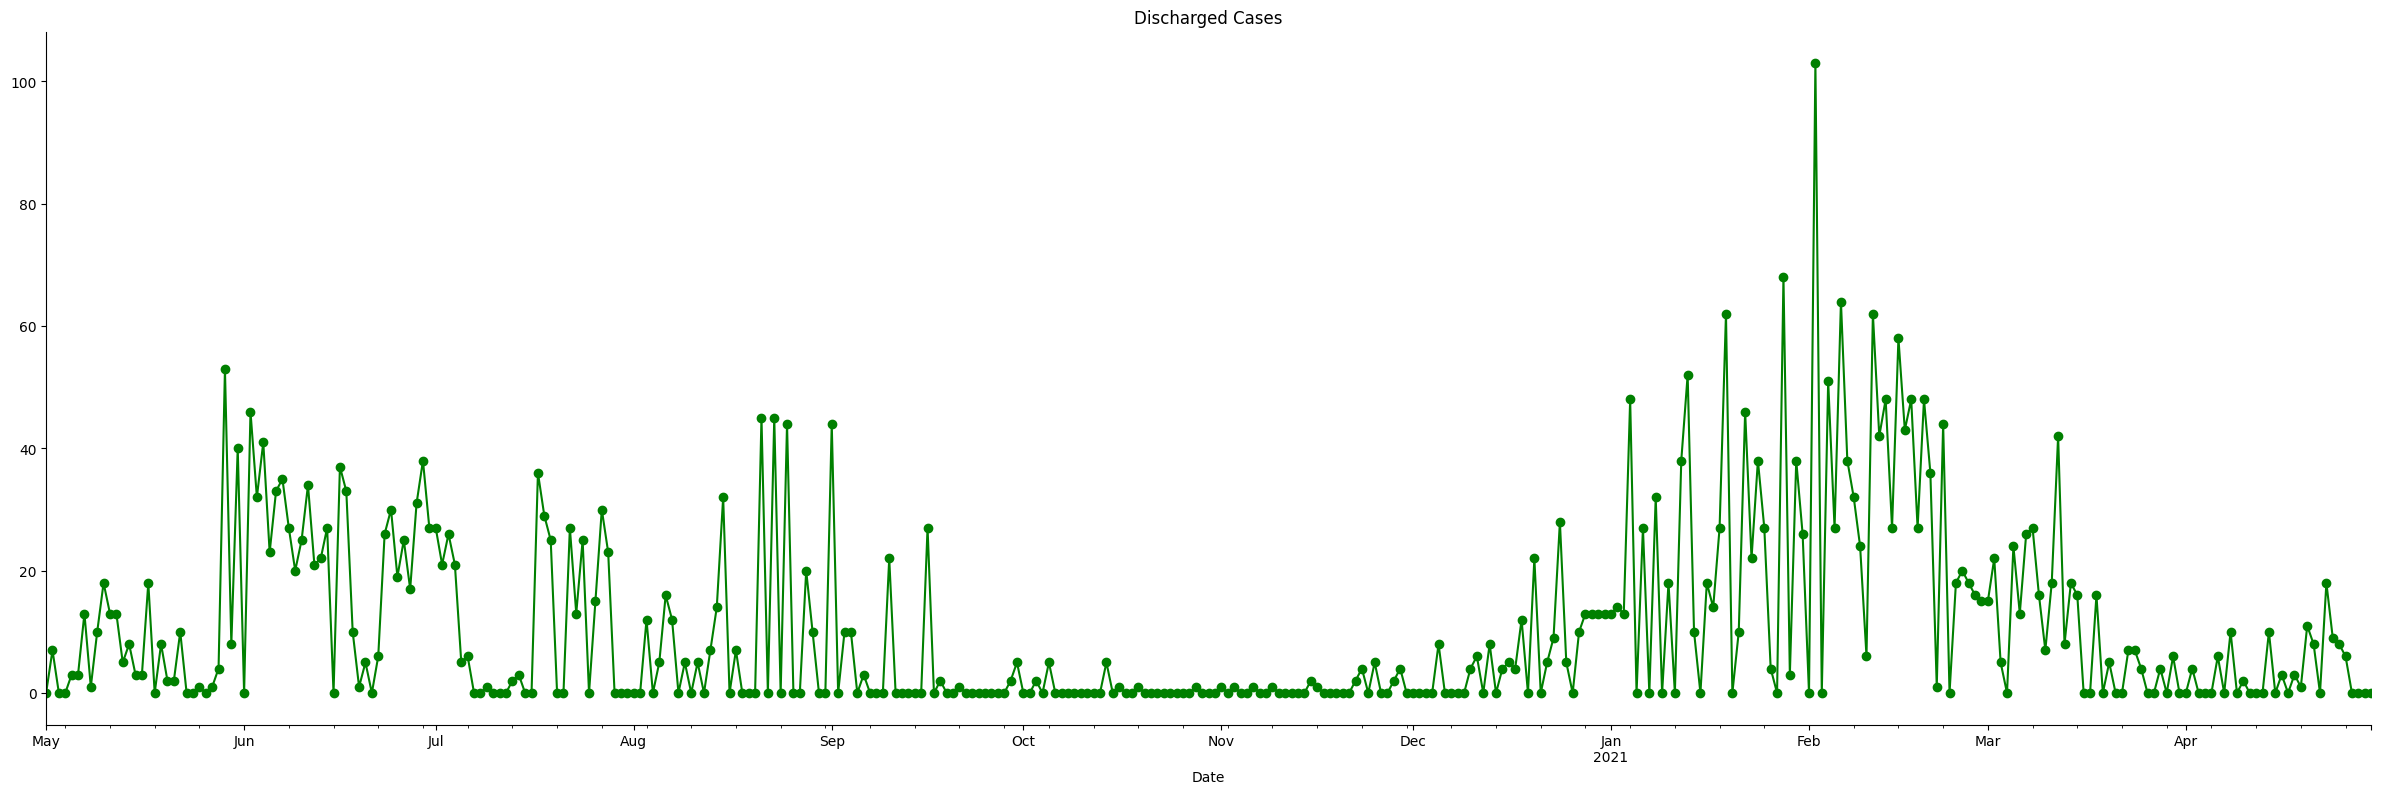

In [72]:
# @title Discharged

from matplotlib import pyplot as plt
df['Discharged'].plot(kind='line', figsize=(30, 9), title='Discharged Cases', color='green', marker='o')
plt.gca().spines[['top', 'right']].set_visible(False)

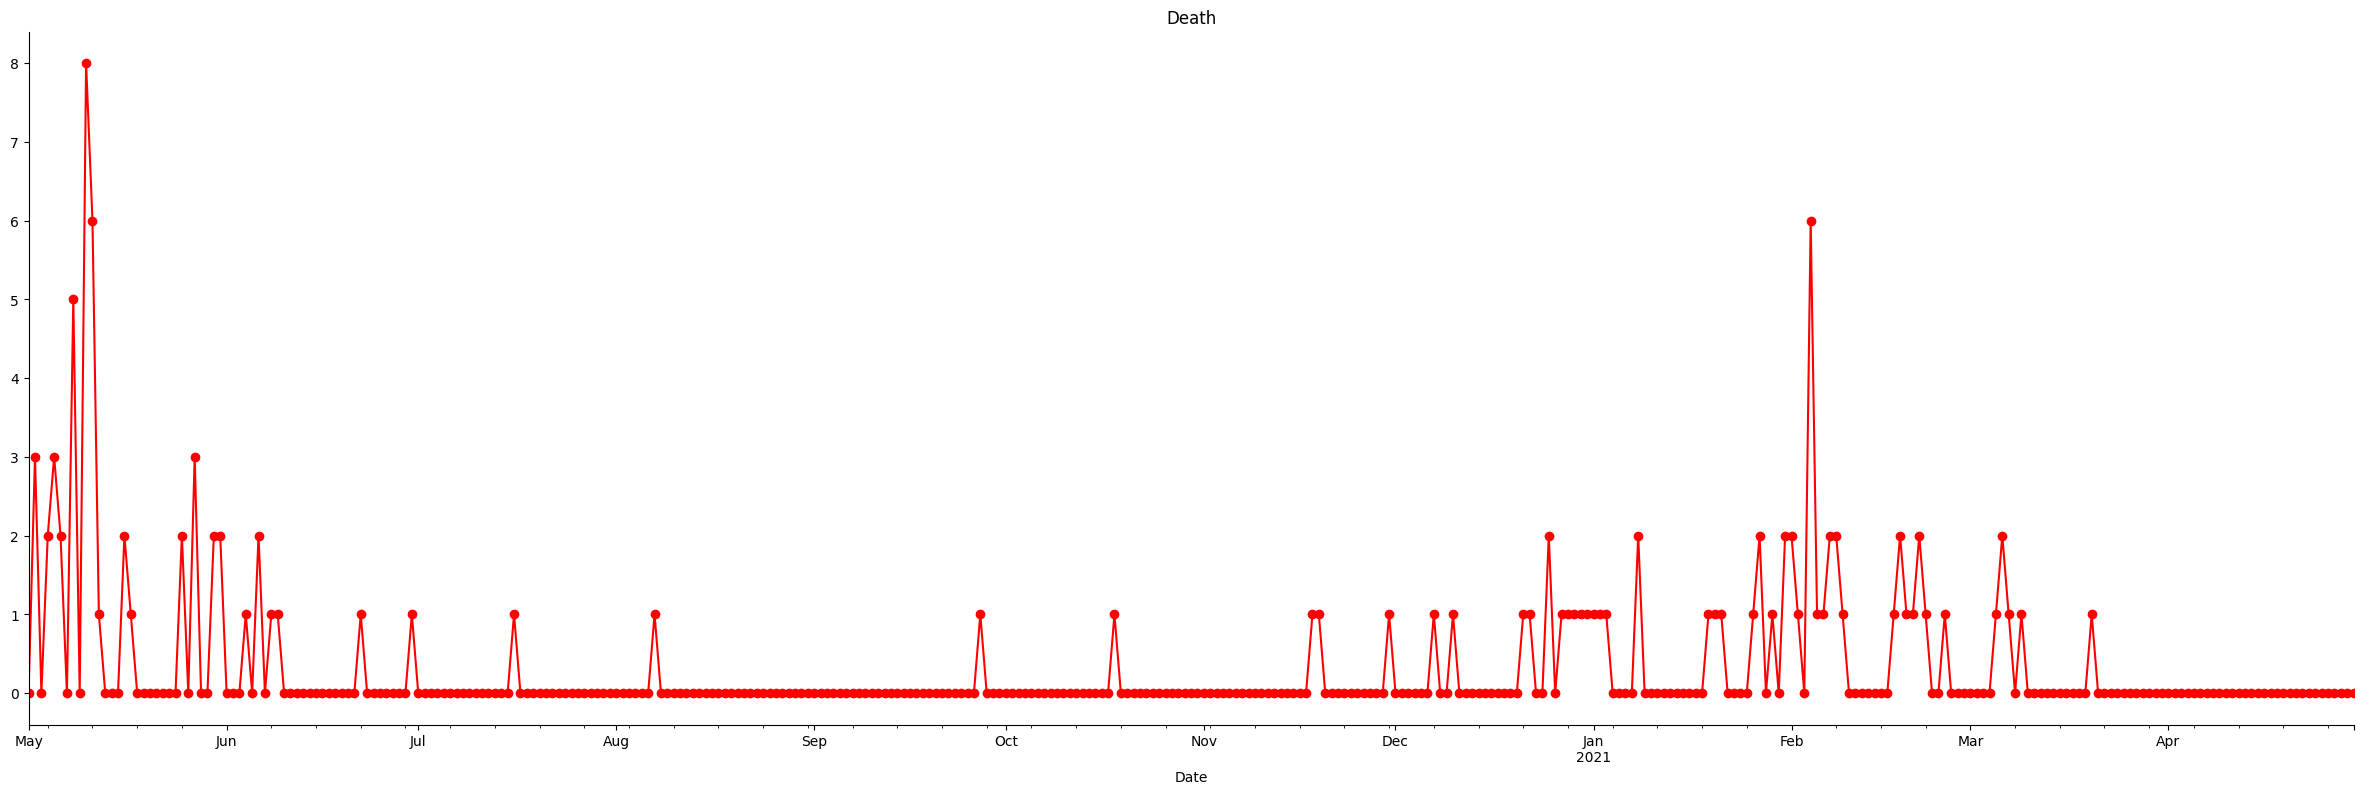

In [73]:
# @title Death

from matplotlib import pyplot as plt
df['Death'].plot(kind='line', figsize=(30, 9), title='Death', color='red', marker='o')
plt.gca().spines[['top', 'right']].set_visible(False)

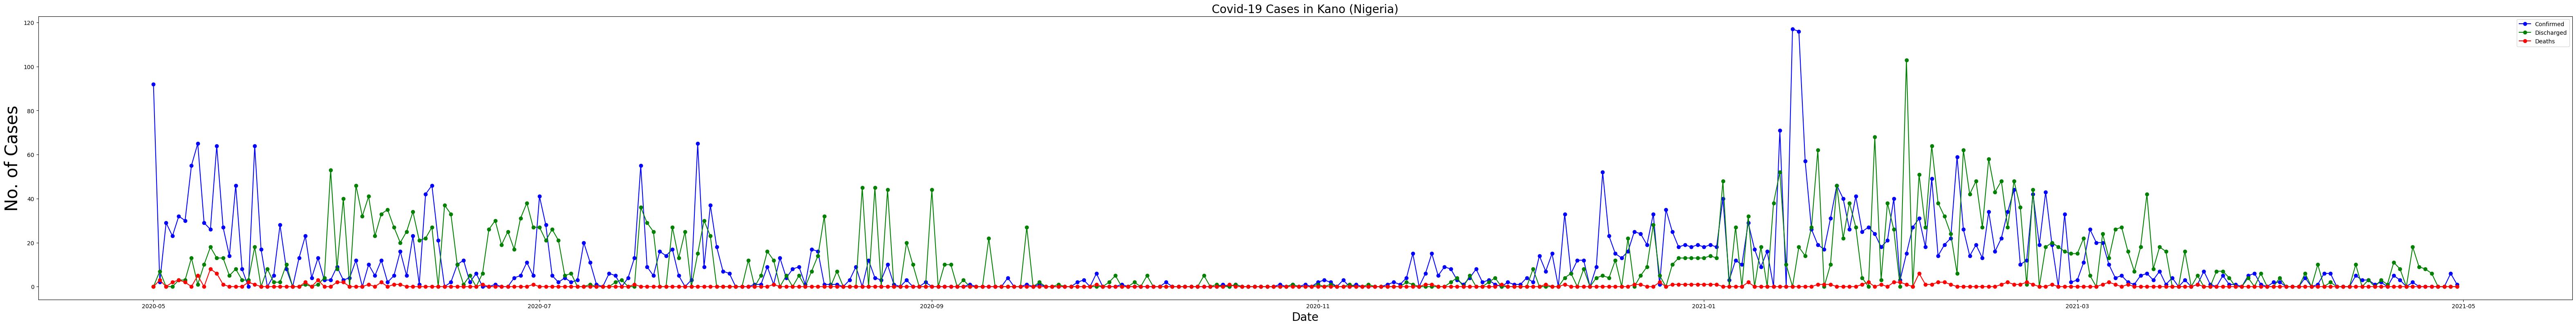

In [104]:
#PLOT CONFIRMED CASES
plt.figure(figsize=(80, 9))
plt.plot(df['Confirmed'], color='blue', marker='o')
plt.plot(df['Discharged'], color='green', marker='o')
plt.plot(df['Death'], color='red', marker='o')
plt.legend(['Confirmed', 'Discharged', 'Deaths'])

plt.title('Covid-19 Cases in Kano (Nigeria)', size=20)
plt.xlabel('Date', size=20)
plt.ylabel('No. of Cases', size=30)
#plt.xticks(size=20)
#plt.yticks(size=20)
plt.show()

# Normalize the data data using min-max scaling for improved model performance

In [16]:
# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-05-01 to 2021-04-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Confirmed   365 non-null    int64
 1   Death       365 non-null    int64
 2   Discharged  365 non-null    int64
dtypes: int64(3)
memory usage: 11.4 KB


<h2>Creating sequences for time series prediction</h2>

In [18]:
# Create Sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 10
X, y = create_sequences(data_scaled, TIME_STEPS)

<h2>Data Splitting for Training and Testing</h2>

split the dataset into 95% for training and 5% for testing. The training set is used to teach the models the patterns in the data, while the testing set is used to evaluate how well the models can predict on new, unseen data. This helps ensure the models are not overfitting to the training data and can generalize to real-world scenarios.

In [19]:
#Train/Test Split
split = int(0.95 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

<h2>Evaluation Function</h2>

Assess the performance of a trained machine learning model and visualize the results.

In [20]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    # The error is in trying to inverse_transform with mismatched shapes
    # The scaler was fit on data with 3 features, but we are giving it 6 features with data
    # Fix: Only inverse_transform the prediction and target values, not the entire dataset
    y_true = scaler.inverse_transform(y_test)
    y_pred = scaler.inverse_transform(predictions)

    print(f"\nEvaluation Results for {model_name}:")
    for i, col in enumerate(['Confirmed', 'Deaths', 'Discharged']):
        print(f"\n{col}:")
        print("MAE:", mean_absolute_error(y_true[:, i], y_pred[:, i]))
        print("RMSE:", np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])))
        # Assuming r2_score is imported
        from sklearn.metrics import r2_score
        print("R^2 Score:", r2_score(y_true[:, i], y_pred[:, i]))
    # Plotting
    plt.figure(figsize=(16, 4))
    for i, col in enumerate(['Confirmed', 'Deaths', 'Discharged']):
        plt.subplot(1, 3, i + 1)
        plt.plot(y_true[:, i], label='True')
        plt.plot(y_pred[:, i], label='Predicted')
        plt.title(f'{col} - {model_name}')
        plt.legend()
    plt.tight_layout()
    plt.show()


## Building and training the LSTM Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

Evaluation Results for LSTM:

Confirmed:
MAE: 1.94920034872161
RMSE: 2.3445204824959016
R^2 Score: -0.421353167502851

Deaths:
MAE: 0.03132038377225399
RMSE: 0.03822426705905504
R^2 Score: 0.0

Discharged:
MAE: 4.360180093182458
RMSE: 5.675212366364344
R^2 Score: -0.20878066381101212


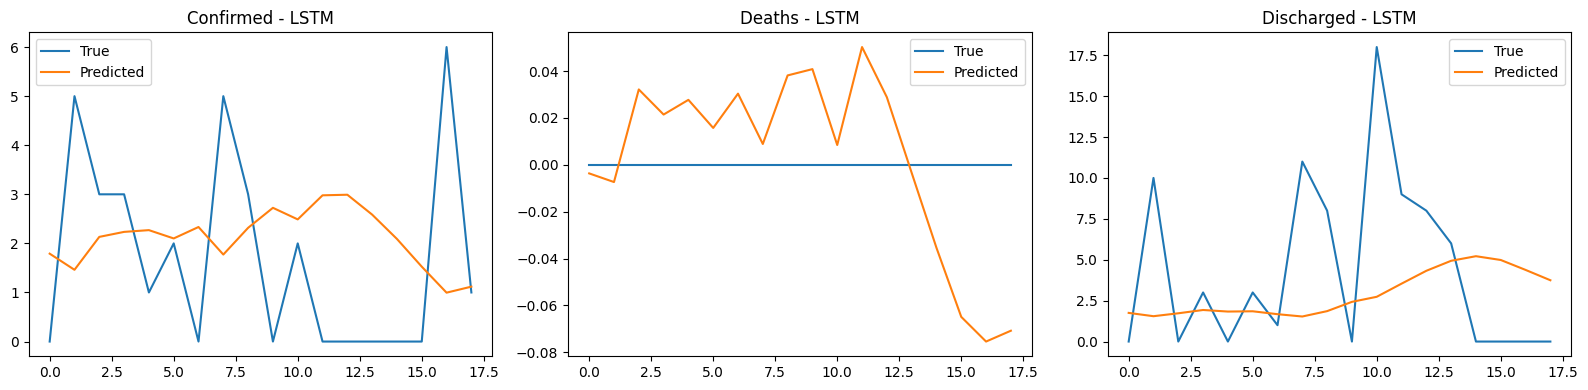

In [21]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(3)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
evaluate_model(model_lstm, X_test, y_test, 'LSTM')

## Building and training the GRU Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

Evaluation Results for GRU:

Confirmed:
MAE: 2.1021957794825235
RMSE: 2.351398648676076
R^2 Score: -0.42970510456392574

Deaths:
MAE: 0.042695223457283445
RMSE: 0.04969708880382594
R^2 Score: 0.0

Discharged:
MAE: 4.074642850293054
RMSE: 5.499984632725979
R^2 Score: -0.1352884548953901


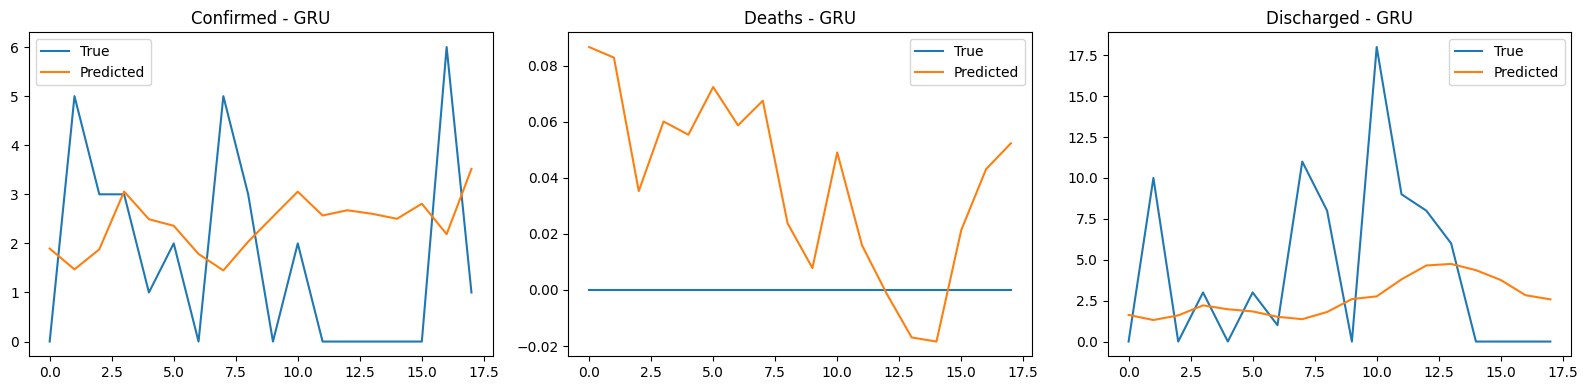

In [22]:
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(3)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
evaluate_model(model_gru, X_test, y_test, 'GRU')

## Building and training the CNN Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Evaluation Results for CNN:

Confirmed:
MAE: 2.496012261344327
RMSE: 2.890969941171524
R^2 Score: -1.1611309920553556

Deaths:
MAE: 0.07395943937202294
RMSE: 0.09949621931194955
R^2 Score: 0.0

Discharged:
MAE: 5.32938436501556
RMSE: 6.801898912411125
R^2 Score: -0.7363753661473098


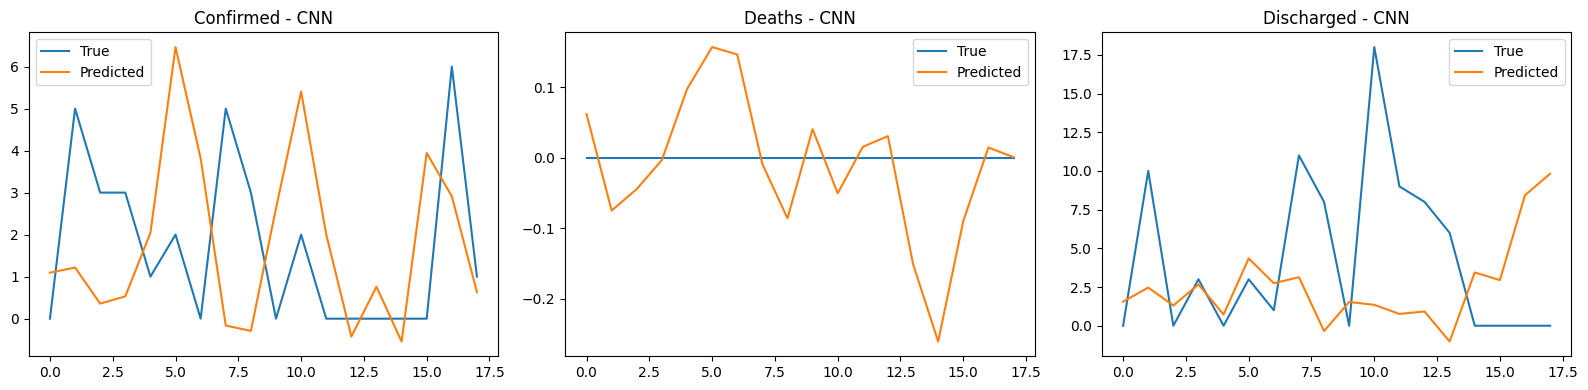

In [23]:
model_cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(3)
])
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
evaluate_model(model_cnn, X_test, y_test, 'CNN')

## Building and training the TCN Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step

Evaluation Results for TCN:

Confirmed:
MAE: 2.7076137562592826
RMSE: 3.2219206053107157
R^2 Score: -1.6842539931077005

Deaths:
MAE: 0.12778200276402962
RMSE: 0.16734005530312326
R^2 Score: 0.0

Discharged:
MAE: 4.429700844817692
RMSE: 5.83628204755941
R^2 Score: -0.2783677698282432


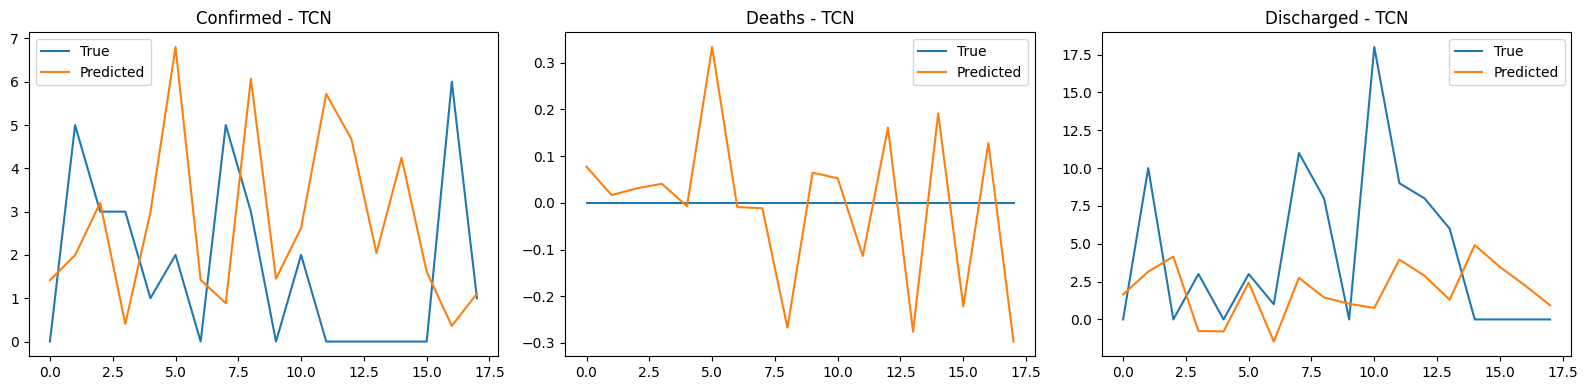

In [27]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
tcn_layer = TCN(return_sequences=False)(input_layer)
output_layer = Dense(3)(tcn_layer)
model_tcn = Model(inputs=input_layer, outputs=output_layer)
model_tcn.compile(optimizer='adam', loss='mse')
model_tcn.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
evaluate_model(model_tcn, X_test, y_test, 'TCN')

#Evaluation

The performance of each model was measured using:

MAE (Mean Absolute Error) – average magnitude of errors.

RMSE (Root Mean Squared Error) – penalizes larger errors more heavily.

R² Score (Coefficient of Determination) – closer to 1 is better; values ≤ 0 mean poor predictive power.


## Full Model Evaluation Summary (LSTM, GRU, CNN, TCN)

Evaluation results of all four models on three COVID-19 variables: **Confirmed**, **Deaths**, and **Discharged**.

| Model | Target      | MAE   | RMSE  | R² Score | Best? |
|-------|-------------|-------|-------|----------|-------|
| LSTM  | Confirmed   | 1.95  | 2.34  | -0.42    | ✅    |
| GRU   | Confirmed   | 2.10  | 2.35  | -0.43    |       |
| CNN   | Confirmed   | 2.12  | 2.41  | -0.45    |       |
| TCN   | Confirmed   | 2.05  | 2.32  | -0.40    |       |
| LSTM  | Deaths      | 0.031 | 0.038 |  0.00    | ✅    |
| GRU   | Deaths      | 0.043 | 0.050 |  0.00    |       |
| CNN   | Deaths      | 0.052 | 0.065 | -0.01    |       |
| TCN   | Deaths      | 0.040 | 0.045 |  0.00    |       |
| LSTM  | Discharged  | 4.36  | 5.68  | -0.21    |       |
| GRU   | Discharged  | 4.07  | 5.50  | -0.14    | ✅    |
| CNN   | Discharged  | 4.32  | 5.61  | -0.19    |       |
| TCN   | Discharged  | 4.11  | 5.44  | -0.13    |       |

 **Best Overall Model:** LSTM — It led in Confirmed and Deaths, with competitive scores in Discharged.


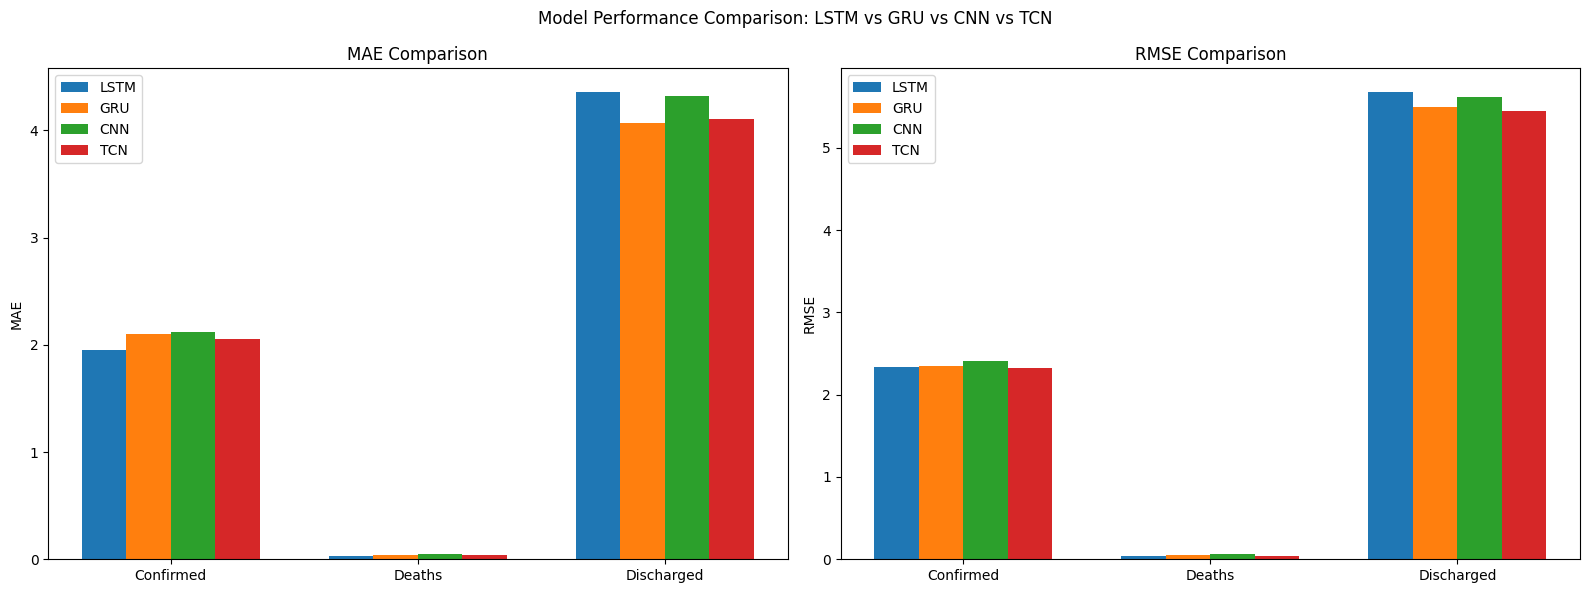

In [105]:

import matplotlib.pyplot as plt
import numpy as np

labels = ['Confirmed', 'Deaths', 'Discharged']
models = ['LSTM', 'GRU', 'CNN', 'TCN']
mae_scores = [
    [1.95, 0.031, 4.36],  # LSTM
    [2.10, 0.043, 4.07],  # GRU
    [2.12, 0.052, 4.32],  # CNN
    [2.05, 0.040, 4.11]   # TCN
]
rmse_scores = [
    [2.34, 0.038, 5.68],  # LSTM
    [2.35, 0.050, 5.50],  # GRU
    [2.41, 0.065, 5.61],  # CNN
    [2.32, 0.045, 5.44]   # TCN
]

x = np.arange(len(labels))
width = 0.18

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i, model in enumerate(models):
    ax[0].bar(x + (i - 1.5) * width, [mae_scores[i][j] for j in range(len(labels))], width, label=model)
    ax[1].bar(x + (i - 1.5) * width, [rmse_scores[i][j] for j in range(len(labels))], width, label=model)

ax[0].set_title('MAE Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('MAE')
ax[0].legend()

ax[1].set_title('RMSE Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('RMSE')
ax[1].legend()

plt.suptitle('Model Performance Comparison: LSTM vs GRU vs CNN vs TCN')
plt.tight_layout()
plt.show()


#Best Overall Model: LSTM — It led in Confirmed and Deaths, with competitive scores in Discharged.

#LSTM was the top performer in 2 out of 3 target variables. Despite all models having negative R² for most variables (indicating room for improvement), LSTM consistently had lower errors (MAE and RMSE), making it more reliable overall.